# Demo SEA data calculations
This demonstrates the use of low-level routines to replicate signal analysis performed by SEA. The analysis parameters are close, but not identical.

### Generate fake data

In [1]:
from edge_analysis.io import simulated_awgn

duration = 4
fs = 14e6
analysis_bandwidth = 10e6

raw_iq = simulated_awgn(duration, fs)

### Analysis bandpass filter

In [2]:
from edge_analysis import channel_analysis
from scipy import signal

sos = channel_analysis.generate_iir_lpf(
    rp_dB=0.1,
    rs_dB=70,
    cutoff_Hz=analysis_bandwidth/2,
    width_Hz=250e3,
    fs = fs,
).astype('float32')

%timeit -n1 -r1 signal.sosfilt(sos, raw_iq)
iq = signal.sosfilt(sos, raw_iq)

986 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Channel power time-series

In [3]:
import iqwaveform
from edge_analysis import channel_analysis

detector_period = 10e-3

pvt = channel_analysis.power_time_series(
    iq, fs=fs, detector_period=detector_period, detectors=('rms', 'peak')
)

%timeit -n1 -r1 channel_analysis.power_time_series(iq, fs=fs, detector_period=detector_period, detectors=('rms', 'peak'))

402 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


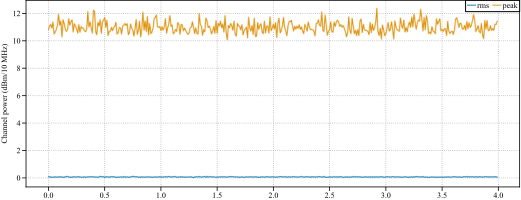

In [4]:
from iqwaveform import powtodB
from iqwaveform.env import set_caption
from matplotlib import pyplot as plt
import numpy as np

plt.style.use('iqwaveform.ieee_double_column')

for detector, trace in pvt.items():
    plt.plot(
        np.arange(trace.size)*detector_period,
        powtodB(trace),
        rasterized=True,
        label=detector
    )

plt.legend(ncol=3)
plt.title('power vs time M3 statistics', visible=False)
plt.ylabel('Channel power (dBm/10 MHz)');

### Cyclic channel power

In [5]:
from iqwaveform.power_analysis import iq_to_cyclic_power

cyclic_power_resolution = 1e-3/14/4

%timeit -n1 -r1 iq_to_cyclic_power(\
    iq, 1/fs,\
    cyclic_period=detector_period,\
    detector_period=cyclic_power_resolution,\
    detectors=list(pvt.keys()),\
    cycle_stats=('min', 'mean', 'max'),\
)

powerstats_cyclic = iq_to_cyclic_power(
    iq, 1/fs,
    cyclic_period=detector_period,
    detector_period=cyclic_power_resolution,
    detectors=list(pvt.keys()),
    cycle_stats=('min', 'mean', 'max'),
)

397 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


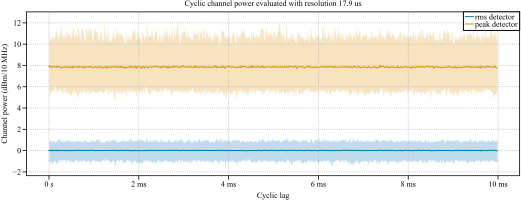

In [6]:
from matplotlib.ticker import EngFormatter

fig, ax = plt.subplots()

for i, (detector, cyclic_traces) in enumerate(powerstats_cyclic.items()):
    t = np.arange(cyclic_traces['mean'].size) * cyclic_power_resolution

    ax.plot(t, powtodB(cyclic_traces['mean']), label=f'{detector} detector', color=f'C{i}', lw=1)

    ax.fill_between(
        t,
        powtodB(cyclic_traces['min']),
        powtodB(cyclic_traces['max']),
        color=f'C{i}',
        alpha=0.25,
        lw=0,
        rasterized=True,
    )

ax.xaxis.set_major_formatter(EngFormatter(unit='s'))
ax.legend()
ax.set_xlabel('Cyclic lag')
ax.set_ylabel('Channel power (dBm/10 MHz)')

ax.set_title(f'Cyclic channel power evaluated with resolution {cyclic_power_resolution/1e-6:0.1f} us');

### Persistence Spectrum

In [7]:
frequency_resolution = 16e3
spectrum_quantiles = [0.1,0.25,0.5,0.75,0.9,0.95,0.99,0.999,1]

%timeit -n1 -r1 channel_analysis.persistence_spectrum(iq, fs=fs, window='flattop', fres=frequency_resolution, quantiles=spectrum_quantiles)
freqs, spectrum = channel_analysis.persistence_spectrum(iq, fs=fs, window='flattop', fres=frequency_resolution, quantiles=spectrum_quantiles)

1.57 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


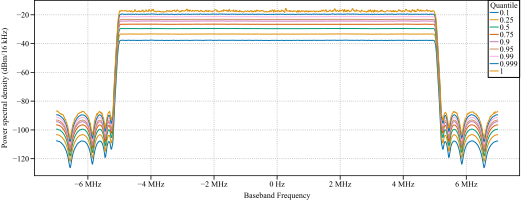

In [8]:
fig, ax = plt.subplots()

ax.plot(freqs, spectrum)
ax.legend(spectrum_quantiles, title='Quantile')
ax.set_xlabel('Baseband Frequency')
ax.xaxis.set_major_formatter(EngFormatter(unit='Hz'))
ax.set_ylabel(f'Power spectral density (dBm/{frequency_resolution/1e3:0.0f} kHz)');

### Amplitude Probability Distribution

2.43 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


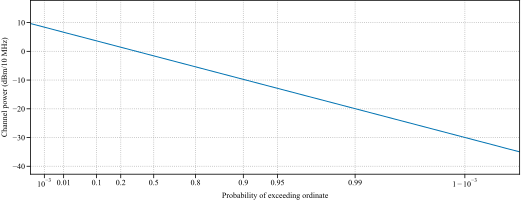

In [9]:
apd_bins = dict(power_low=-40, power_high=15, power_count=161)

%timeit -n1 -r1 channel_analysis.amplitude_probability_distribution(iq, **apd_bins)
ccdf, bins = channel_analysis.amplitude_probability_distribution(iq, **apd_bins)

fig, ax = plt.subplots()
ax.plot(ccdf, bins);
ax.set_xscale('gamma-qq', k=1, major_ticks=16, db_ordinal=True)
ax.set_ylabel(f'Channel power (dBm/{analysis_bandwidth/1e6:0.0f} MHz)');
ax.set_xlabel('Probability of exceeding ordinate');